# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

### Initialize the model

In [3]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

### Scrape high-level Sciensano data

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-07-06,169,27,9,6,712,1.0,0.0,0.0,0.0,0.0,1.0
2020-07-07,178,32,15,16,711,3.0,0.0,1.0,0.0,0.0,2.0
2020-07-08,165,32,9,21,699,1.0,0.0,0.0,0.0,1.0,0.0
2020-07-09,160,36,10,20,689,1.0,0.0,0.0,0.0,0.0,1.0
2020-07-10,143,32,6,17,678,0.0,0.0,0.0,0.0,0.0,0.0


### Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

In [5]:
# define dataset
data=[df_sciensano["H_in"].values[:8]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

No constraints given.
Best after iteration 1: [38.91279623 35.91669027  0.05249858] 37.00989531948314
Best after iteration 2: [38.91279623 35.91669027  0.05249858] 37.00989531948314
New best for swarm at iteration 3: [5.94125335e+01 4.28468422e+01 4.37927107e-02] 35.87128423068879
Best after iteration 3: [5.94125335e+01 4.28468422e+01 4.37927107e-02] 35.87128423068879
Best after iteration 4: [5.94125335e+01 4.28468422e+01 4.37927107e-02] 35.87128423068879
New best for swarm at iteration 5: [5.51694995e+01 4.74791674e+01 4.07744122e-02] 34.11242481412788
Best after iteration 5: [5.51694995e+01 4.74791674e+01 4.07744122e-02] 34.11242481412788
Best after iteration 6: [5.51694995e+01 4.74791674e+01 4.07744122e-02] 34.11242481412788
Best after iteration 7: [5.51694995e+01 4.74791674e+01 4.07744122e-02] 34.11242481412788
Best after iteration 8: [5.51694995e+01 4.74791674e+01 4.07744122e-02] 34.11242481412788
Best after iteration 9: [5.51694995e+01 4.74791674e+01 4.07744122e-02] 34.1124248141

In [6]:
lag_time = int(round(theta[1]))
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [7]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))

pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [24:21<00:00,  6.84it/s]


In [9]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [8]:
sampler.get_autocorr_time()

array([46.72978801, 52.47533579])

In [18]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.03677070760503486 0.03641053186143065 0.03712577993915905


Initialize a dictionary of samples and write them to `parameters.json`

In [11]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [12]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

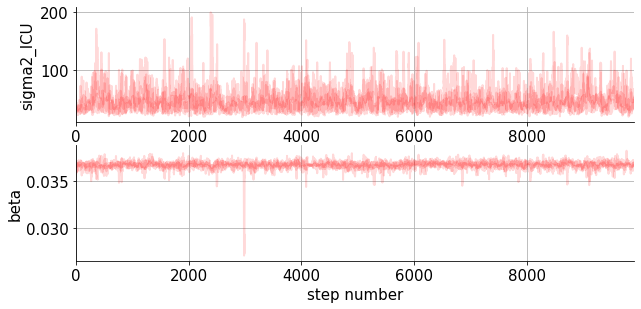

In [13]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

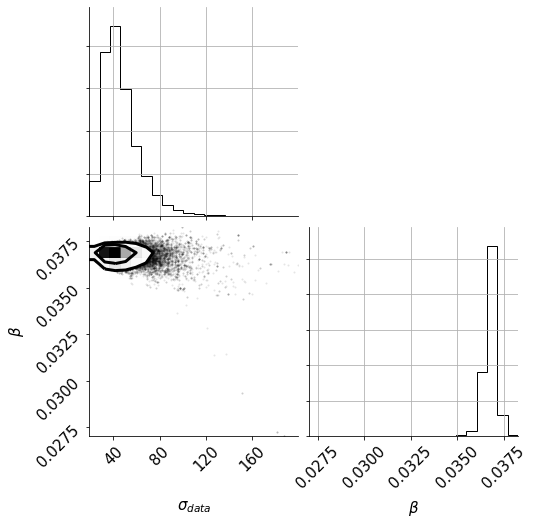

In [14]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

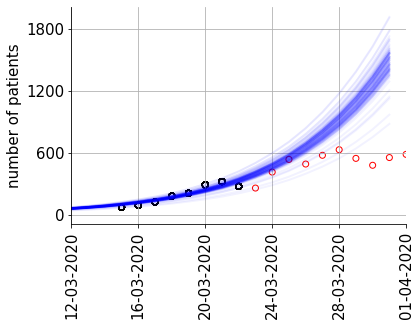

In [15]:
T = 9
fig,ax=plt.subplots()

for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
#legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance ramp parameters

#### Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [19]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [20]:
samples_beta = {'beta': samples_dict['beta']}

#### Initial guess for MCMC with PSO

In [21]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }
# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(0.1,20),(0,20),(0,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=samples_beta,maxiter=200,popsize=100)

No constraints given.
Best after iteration 1: [64.86473734  0.69280012  8.23537852  0.16846561] 175.29844130536927
Best after iteration 2: [64.86473734  0.69280012  8.23537852  0.16846561] 175.29844130536927
New best for swarm at iteration 3: [83.1071437   2.55093288  5.1014479   0.27718203] 174.8107691352612
Best after iteration 3: [83.1071437   2.55093288  5.1014479   0.27718203] 174.8107691352612
Best after iteration 4: [83.1071437   2.55093288  5.1014479   0.27718203] 174.8107691352612
Best after iteration 5: [83.1071437   2.55093288  5.1014479   0.27718203] 174.8107691352612
New best for swarm at iteration 6: [84.82798679  5.48320583  3.09625828  0.27824866] 173.75973232600808
Best after iteration 6: [84.82798679  5.48320583  3.09625828  0.27824866] 173.75973232600808
New best for swarm at iteration 7: [73.31235367  2.97984588  4.89731504  0.30530391] 171.3803021601987
Best after iteration 7: [73.31235367  2.97984588  4.89731504  0.30530391] 171.3803021601987
Best after iteration 

Best after iteration 70: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 71: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 72: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 73: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 74: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 75: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 76: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 77: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 78: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 79: [55.06934717  3.05234058  5.24149113  0.29032405] 166.69587623359538
Best after iteration 80: [55.06934717  3.05234058  5.2414911

Best after iteration 149: [54.4693977   3.02587166  5.28941078  0.29037122] 166.68994178685304
Best after iteration 150: [54.4693977   3.02587166  5.28941078  0.29037122] 166.68994178685304
Best after iteration 151: [54.4693977   3.02587166  5.28941078  0.29037122] 166.68994178685304
Best after iteration 152: [54.4693977   3.02587166  5.28941078  0.29037122] 166.68994178685304
Best after iteration 153: [54.4693977   3.02587166  5.28941078  0.29037122] 166.68994178685304
Best after iteration 154: [54.4693977   3.02587166  5.28941078  0.29037122] 166.68994178685304
New best for swarm at iteration 155: [55.17696792  3.01170073  5.28762123  0.29022488] 166.6861651440138
Best after iteration 155: [55.17696792  3.01170073  5.28762123  0.29022488] 166.6861651440138
Best after iteration 156: [55.17696792  3.01170073  5.28762123  0.29022488] 166.6861651440138
Best after iteration 157: [55.17696792  3.01170073  5.28762123  0.29022488] 166.6861651440138
Best after iteration 158: [55.17696792  3.0

In [22]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2]

}
)
prevention = theta[2]
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

In [23]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,samples_beta))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [1:15:07<00:00,  2.22it/s]


In [24]:
sampler.get_autocorr_time()

array([189.36500549, 174.15105526, 168.73131068, 194.120643  ])

In [25]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [26]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [27]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [28]:
mean = np.mean(flat_samples[:,3])
p10 = np.percentile(flat_samples[:,3],10)
p90 = np.percentile(flat_samples[:,3],90)
print(mean,p10,p90)

0.281094817150477 0.24158051275253273 0.32002331486509156


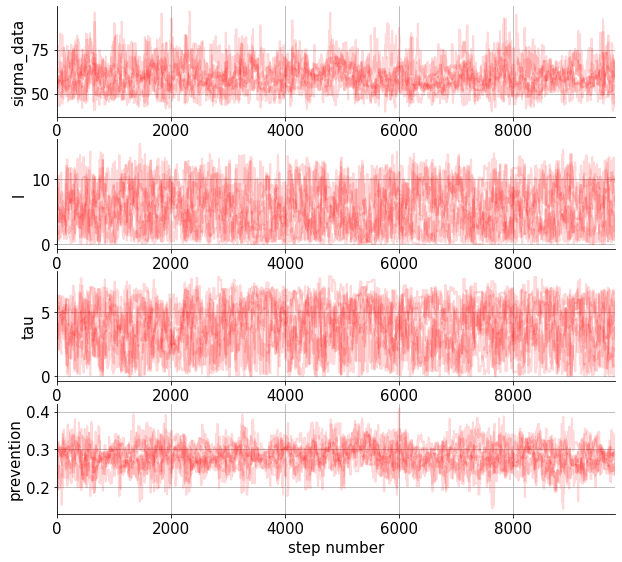

In [29]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

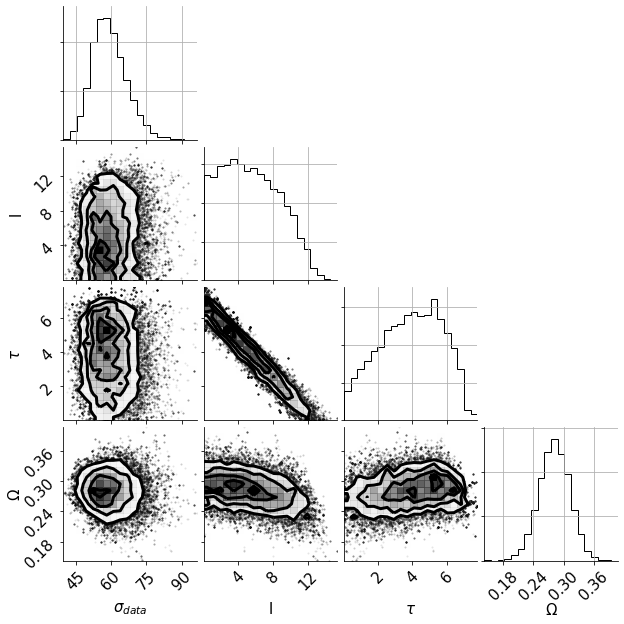

In [32]:
import corner

fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

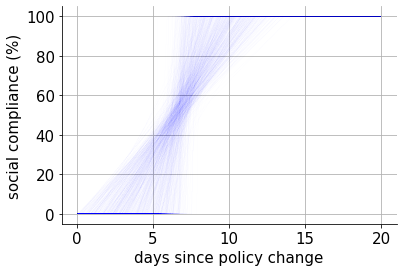

In [55]:
fig,ax=plt.subplots()
t = np.linspace(0,20,400)
for i in range(1000):
    idx,l= random.choice(list(enumerate(flat_samples[:,1])))
    tau = samples_dict['tau'][idx]
    y=[]
    for j in range(len(t)):
        y.append(100*ramp_2(t[j],0,1,l,tau))
    ax.plot(t,y,color='blue',linewidth=0.1,alpha=0.05)
ax.set_xlabel('days since policy change')
ax.set_ylabel('social compliance (%)')
plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

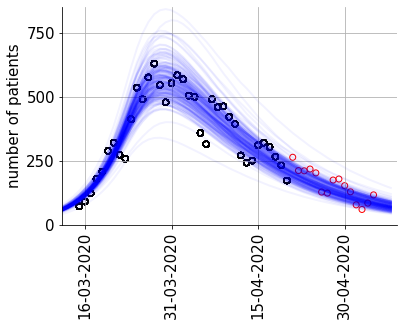

In [60]:
import random
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibration of hospitalization parameters

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [61]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

In [62]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

model.parameters['dICUrec'] = 8

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(2,30),(2,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=50,popsize=50)

No constraints given.
New best for swarm at iteration 1: [149.07037906 233.75258012 341.40587512  15.00999791   9.48748352] 933.5509411365501
Best after iteration 1: [149.07037906 233.75258012 341.40587512  15.00999791   9.48748352] 933.5509411365501
Best after iteration 2: [149.07037906 233.75258012 341.40587512  15.00999791   9.48748352] 933.5509411365501
New best for swarm at iteration 3: [132.39443374 248.3966681  342.21797221  13.10527492   8.61152885] 931.5331416997437
Best after iteration 3: [132.39443374 248.3966681  342.21797221  13.10527492   8.61152885] 931.5331416997437
Best after iteration 4: [132.39443374 248.3966681  342.21797221  13.10527492   8.61152885] 931.5331416997437
New best for swarm at iteration 5: [109.94686395 255.97891698 205.64063825  15.57373941   8.08543573] 910.3010087558266
Best after iteration 5: [109.94686395 255.97891698 205.64063825  15.57373941   8.08543573] 910.3010087558266
Best after iteration 6: [109.94686395 255.97891698 205.64063825  15.57373

In [63]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4]
}
)

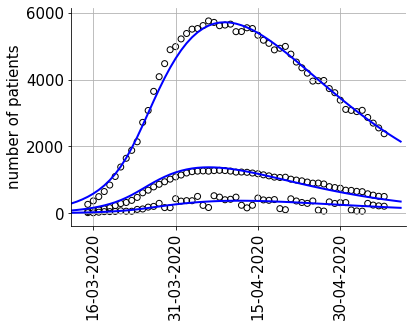

In [64]:
T = 3
fig,ax=plt.subplots()
for i in range(1):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 1})

In [65]:
pos = theta + [5,5,5,3,3]* np.random.randn(10, 5)
bounds=((1,500),(1,500),(1,1000),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 16000, progress=True);

100%|██████████| 16000/16000 [2:44:40<00:00,  1.62it/s]  


In [66]:
sampler.get_autocorr_time()

array([69.18109143, 63.51788537, 66.19165968, 62.44097252, 63.33101562])

In [67]:
samples = sampler.get_chain(discard=50,flat=False)
flat_samples = sampler.get_chain(discard=50,flat=True)

In [72]:
mean = np.mean(samples_dict['dICU'])
p10 = np.percentile(samples_dict['dICU'],10)
p90 = np.percentile(samples_dict['dICU'],90)
print(mean,p10,p90)

8.307525596994928 8.128592958444369 8.484993309942656


In [68]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist()})

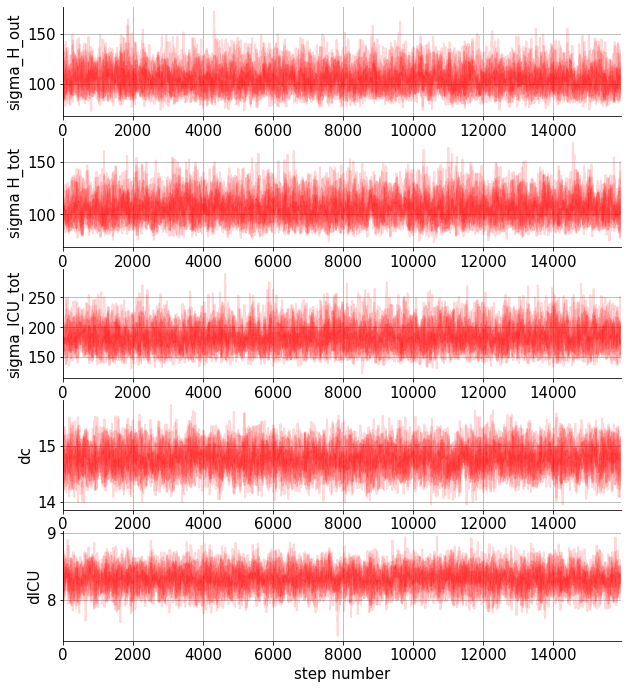

In [69]:
traceplot(samples=sampler.get_chain(discard=50),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

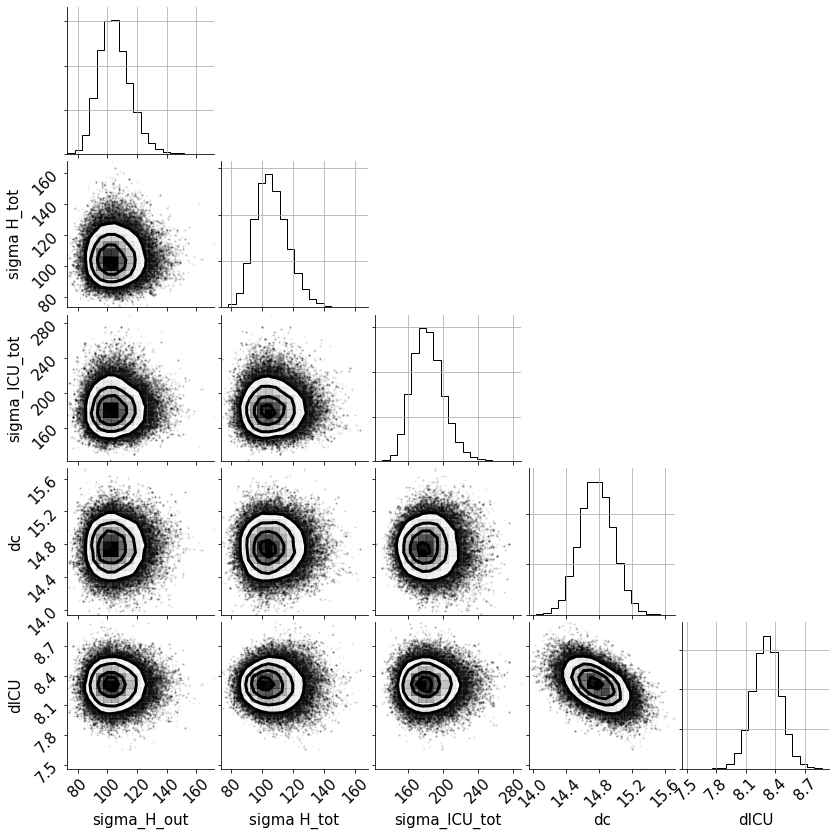

In [70]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],
);
fig.set_size_inches(12, 12)
plt.savefig('corner_compliance_hospitalization.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

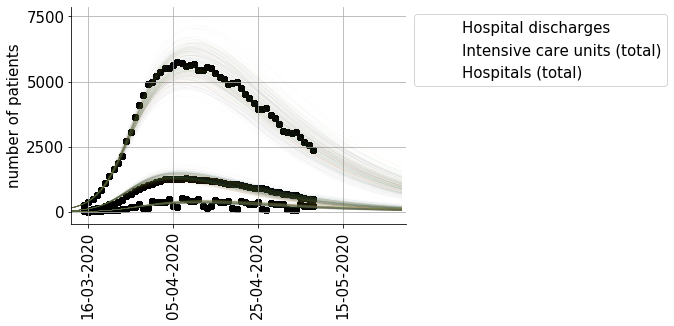

In [35]:
T = 21

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.10,'alpha': 0.15})

In [73]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

2.8606658225683534 2.8326450825022675 2.888289530593747


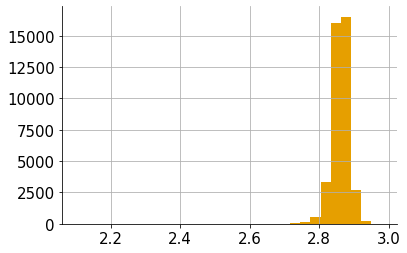

In [16]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

1.6371595958661558 1.6211233209819833 1.6529686492377154
2.0056305846013673 1.9859850696179884 2.0249977379538295
4.414393932051874 4.371154143627976 4.457021046385204
5.177462245653499 5.126748064834861 5.227457846068659
4.068346953429086 4.028496757862258 4.107632502793474
2.9883170100032928 2.959045903426717 3.0171733678205563
1.4771816171230114 1.4627123555275965 1.4914458605624112
0.8366881225845482 0.8284926108213906 0.844767510335558
0.9272265339806824 0.9181441820729287 0.9361801960428541


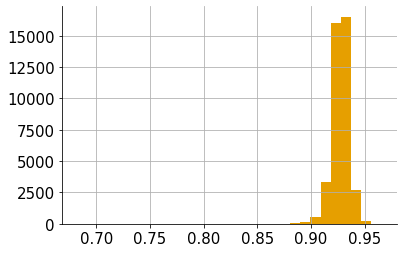

In [17]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

# Notebook works till here

### Scenarios

In [5]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

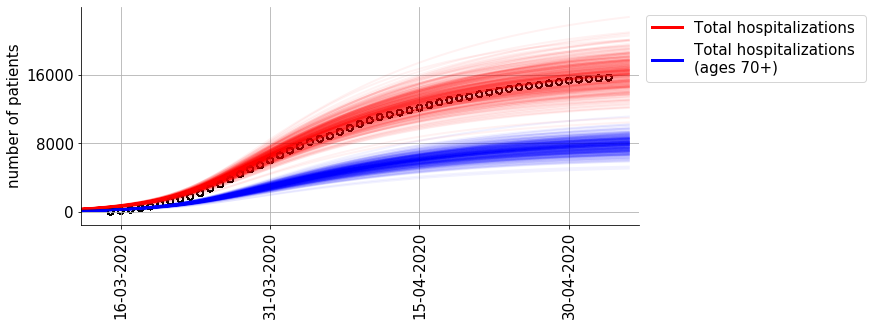

In [11]:
import random
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #idx,model.parameters['dc'] = random.choice(list(enumerate(samples_dict['dc'])))
    #model.parameters['dICU'] = samples_dict['dICU'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + lag_time + T) - datetime.timedelta(days=lag_time)
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)):
        # ages 60 plus
        #data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        #val = y_model[states[i]].to_array(dim="states").values[:,6:,:].sum(axis=1)
        #csum=np.cumsum(val)
        #lines = ax.plot(idx,csum,color='green',linewidth= 2,alpha= 0.05)    
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[lag_time:-T],np.cumsum(data[i]),color="black",facecolors='none')
    

    # Attributes
    #if legend_text is not None:
    #    leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
    #if titleText is not None:
    #    ax.set_title(titleText,{'fontsize':18})

    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[lag_time-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

In [12]:
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [13]:
T = 62
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods=data[0].size + lag_time + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

2020-03-16 00:00:00 2020-05-04 00:00:00 2020-05-06 00:00:00 2020-05-11 00:00:00 2020-05-18 00:00:00 2020-06-04 00:00:00 2020-07-01 00:00:00 2020-09-01 00:00:00


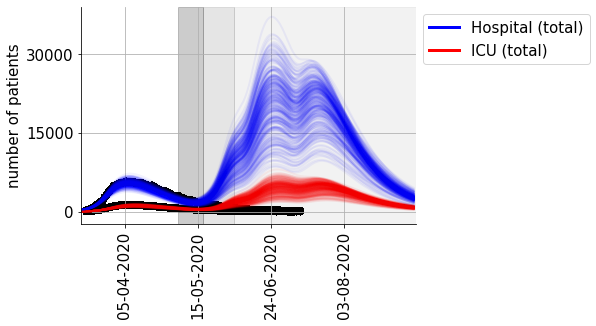

In [14]:
T = 62

fig,ax=plt.subplots()

ax.axvspan(index[50], index[64], alpha=0.20, color='black')
ax.axvspan(index[64], index[81], alpha=0.10, color='black')
ax.axvspan(index[81], index[-1], alpha=0.05, color='black')

for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
#fig.set_size_inches(10, 4)
plt.savefig('lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

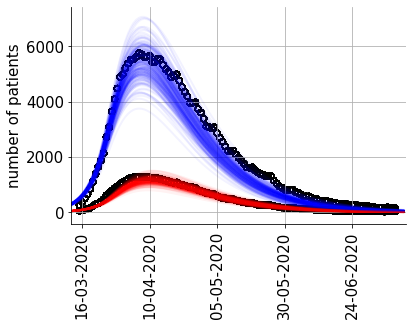

In [21]:
T = 3

fig,ax=plt.subplots()

for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                     ]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#for lh in leg.get_lines(): 
#    lh.set_alpha(1)
#fig.set_size_inches(6, 4)
plt.savefig('continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

Text(0, 0.5, "fraction 'immune'")

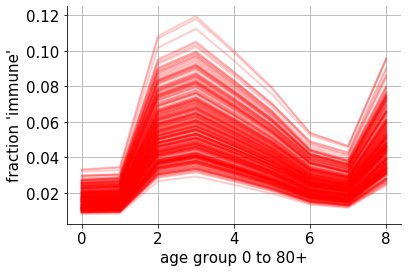

In [19]:
fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57], 
          'Nc':      [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.2*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.1*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    #ax.plot(1-y_model["S"][:,lag_time+15]/y_model["S"][:,0],alpha=0.2,color='blue',linewidth=0.1)
    ax.plot(1-y_model["S"][:,lag_time+36]/y_model["S"][:,0],alpha=0.2,color='red',linewidth=2)
ax.set_xlabel('age group 0 to 80+')
ax.set_ylabel("fraction 'immune'" )

### Re-estimating beta

In [12]:
samples_dict.keys()

dict_keys(['lag_time', 'beta', 'l', 'tau', 'prevention'])

In [6]:
T = 62
from copy import deepcopy
# Create checkpoints dictionary
# checkpoints are hardcoded!
# Create a dictionary of past policies
chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
        'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)],
        'beta': [np.random.choice(samples_dict['beta'],1,replace=False),
                   0.01,
                   0.01,
                   0.01,
                   0.01,
                   0.01,
                   0.01,]
      }


# define dataset
data=[df_sciensano["H_in"].values[50:]]
# Redine lag_time
model.extraTime = lag_time+50
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.04)) # must be a list!

In [7]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=smpls,maxiter=50,popsize=20)

No constraints given.
Best after iteration 1: [1.66095352e+01 1.08097513e-02] 227.5759685714227
Best after iteration 2: [1.66095352e+01 1.08097513e-02] 227.5759685714227
Best after iteration 3: [1.66095352e+01 1.08097513e-02] 227.5759685714227
Best after iteration 4: [1.66095352e+01 1.08097513e-02] 227.5759685714227
New best for swarm at iteration 5: [1.03903371e+01 8.26991980e-03] 214.5108208326445
Best after iteration 5: [1.03903371e+01 8.26991980e-03] 214.5108208326445
New best for swarm at iteration 6: [1.34931086e+01 9.02748568e-03] 207.02023950901412
Best after iteration 6: [1.34931086e+01 9.02748568e-03] 207.02023950901412
Best after iteration 7: [1.34931086e+01 9.02748568e-03] 207.02023950901412
New best for swarm at iteration 8: [1.38339475e+01 1.14140455e-02] 201.60614558085723
Best after iteration 8: [1.38339475e+01 1.14140455e-02] 201.60614558085723
Best after iteration 9: [1.38339475e+01 1.14140455e-02] 201.60614558085723
New best for swarm at iteration 10: [12.15872595  0

In [8]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.0001,0.10))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,smpls))
sampler.run_mcmc(pos, 12000, progress=True);

  0%|          | 0/12000 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 12000/12000 [4:37:45<00:00,  1.39s/it] 


In [10]:
samples = sampler.get_chain(discard=500,flat=False)
flat_samples = sampler.get_chain(discard=500,flat=True)

In [9]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 240;
tau: [650.19011597 527.66411203]

In [13]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.010387174250515432 0.009751388541836364 0.0111088400688214


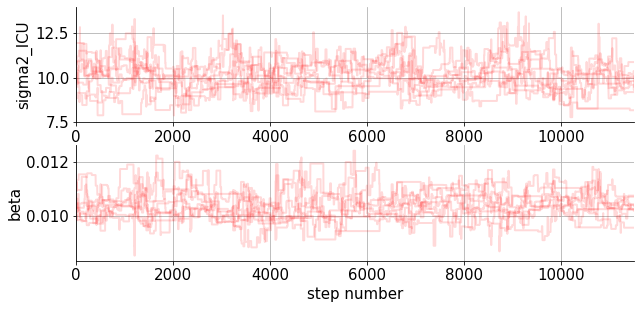

In [11]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

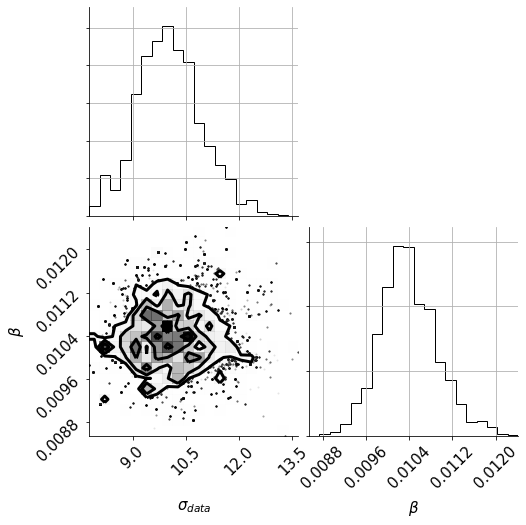

In [12]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [8]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

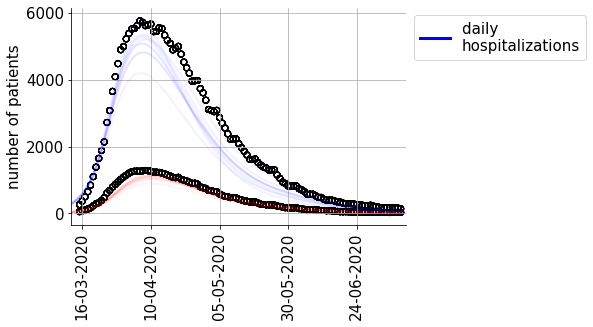

In [10]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(10):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
            'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)],
            'beta': [np.random.choice(samples_dict['beta'],1,replace=False),
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1]
                    ]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [14]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)

In [15]:
print(R_0,np.mean(R_0))

[0.46247307 0.56656061 1.24700018 1.46255555 1.14924709 0.8441548
 0.41728169 0.23635187 0.26192761] 0.7386169401314516
